In [1]:
from textwrap import wrap
import emoji
import joblib
import langdetect
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

plt.style.use("fivethirtyeight")
warnings.filterwarnings("ignore")


In [4]:
def get_category_dict(category_file):
  category = pd.read_json(category_file, orient="records")
  category = pd.DataFrame(category["items"].values.tolist())
  return {
    cat.id: cat.snippet.get("title")
    for cat in category.itertuples(index=False)
  }

In [5]:
category_dict = get_category_dict("D:/archive/category.json")

In [6]:
category_dict

{'1': 'Film & Animation',
 '2': 'Autos & Vehicles',
 '10': 'Music',
 '15': 'Pets & Animals',
 '17': 'Sports',
 '18': 'Short Movies',
 '19': 'Travel & Events',
 '20': 'Gaming',
 '21': 'Videoblogging',
 '22': 'People & Blogs',
 '23': 'Comedy',
 '24': 'Entertainment',
 '25': 'News & Politics',
 '26': 'Howto & Style',
 '27': 'Education',
 '28': 'Science & Technology',
 '30': 'Movies',
 '31': 'Anime/Animation',
 '32': 'Action/Adventure',
 '33': 'Classics',
 '34': 'Comedy',
 '35': 'Documentary',
 '36': 'Drama',
 '37': 'Family',
 '38': 'Foreign',
 '39': 'Horror',
 '40': 'Sci-Fi/Fantasy',
 '41': 'Thriller',
 '42': 'Shorts',
 '43': 'Shows',
 '44': 'Trailers'}

In [8]:
trending = pd.read_csv("D:/archive/trending.csv", parse_dates=["publish_time", "trending_time"])

with pd.option_context("display.max_columns", None):
     display(trending.head())

,video_id,publish_time,channel_id,title,description,thumbnail_url,thumbnail_width,thumbnail_height,channel_name,tags,category_id,live_status,local_title,local_description,duration,dimension,definition,caption,license_status,allowed_region,blocked_region,view,like,dislike,favorite,comment,trending_time
0,NaN,2021-02-05 09:00:34+00:00,UCEf_Bc-KVd7onSeifS3py9g,aespa 에스파 'Forever (약속)' MV,"aespa's new single ""Forever"" is out!\nListen a...",NaN,NaN,NaN,SMTOWN,NaN,10,none,aespa 에스파 'Forever (약속)' MV,"aespa's new single ""Forever"" is out!\nListen a...",PT5M7S,2d,hd,True,True,NaN,NaN,7806846.0,857902.0,24078.0,0,94961.0,2021-02-07 05:46:51.832614+00:00
1,NaN,2021-02-04 15:54:08+00:00,UCYEa4_MC7OFjcWrO6SO-u8g,[FULL] Siapa di Balik Kudeta AHY? | Dua Sisi t...,"Jakarta, https://www.tvonenews.com - Ketua umu...",NaN,NaN,NaN,Indonesia Lawyers Club,"['tvone', 'tv one', 'tvonenews', 'indonesia la...",25,none,[FULL] Siapa di Balik Kudeta AHY? | Dua Sisi t...,"Jakarta, https://www.tvonenews.com - Ketua umu...",PT42M30S,2d,hd,False,True,NaN,NaN,885038.0,6765.0,1263.0,0,6365.0,2021-02-07 05:46:51.832649+00:00
2,NaN,2021-02-06 03:00:22+00:00,UCu12RxQjRQyh79YBYvEDkOg,CABRIOLET CHALLENGE: TANTANGAN MENGGODA (7/12),Road Party Season 2: Cabriolet Challenge\n\nEp...,NaN,NaN,NaN,Motomobi,"['MotoMobi', 'Mobil', 'motor', 'review', 'indo...",2,none,CABRIOLET CHALLENGE: TANTANGAN MENGGODA (7/12),Road Party Season 2: Cabriolet Challenge\n\nEp...,PT46M43S,2d,hd,False,True,NaN,NaN,889708.0,47895.0,532.0,0,8785.0,2021-02-07 05:46:51.832664+00:00
3,NaN,2021-02-05 20:26:08+00:00,UCCuzDCoI3EUOo_nhCj4noSw,With Windah Basudara & Hans,Join this channel to get access to perks:\nhtt...,NaN,NaN,NaN,yb,NaN,20,none,With Windah Basudara & Hans,Join this channel to get access to perks:\nhtt...,PT45M59S,2d,hd,False,True,NaN,NaN,1006854.0,91973.0,3967.0,0,12957.0,2021-02-07 05:46:51.832678+00:00
4,NaN,2021-02-03 23:14:54+00:00,UC14UlmYlSNiQCBe9Eookf_A,🤯 LATE COMEBACK DRAMA! | HIGHLIGHTS | Granada ...,"With just two minutes to play, Barça looked to...",NaN,NaN,NaN,FC Barcelona,"['FC Barcelona', 'برشلونة،', 'Fútbol', 'FUTBOL...",17,none,🤯 LATE COMEBACK DRAMA! | HIGHLIGHTS | Granada ...,"With just two minutes to play, Barça looked to...",PT5M12S,2d,hd,False,True,NaN,NaN,6275035.0,218131.0,4289.0,0,12799.0,2021-02-07 05:46:51.832730+00:00


In [9]:
start_date = trending.trending_time.min()
end_date = trending.trending_time.max()

print(f"{start_date}")
print(f"{end_date}")

2021-02-07 05:46:51.832614+00:00
2022-11-19 06:02:12.845027+00:00


In [10]:
filtered_trending = trending[trending.trending_time.dt.month >= 7]

start_date = filtered_trending.trending_time.min()
end_date = filtered_trending.trending_time.max()

print(f"{start_date}=")
print(f"{end_date}=")

2021-07-01 06:01:25.524449+00:00=
2022-11-19 06:02:12.845027+00:00=


In [11]:
num_videos = filtered_trending.shape[0]
print(f"{num_videos}")

63718


In [12]:
filtered_trending.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63718 entries, 21322 to 118750
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   video_id           31918 non-null  object             
 1   publish_time       63718 non-null  datetime64[ns, UTC]
 2   channel_id         63718 non-null  object             
 3   title              63718 non-null  object             
 4   description        61486 non-null  object             
 5   thumbnail_url      31918 non-null  object             
 6   thumbnail_width    31918 non-null  float64            
 7   thumbnail_height   31918 non-null  float64            
 8   channel_name       63718 non-null  object             
 9   tags               55466 non-null  object             
 10  category_id        63718 non-null  int64              
 11  live_status        63718 non-null  object             
 12  local_title        63718 non-null  object

In [13]:
filtered_trending.dropna(subset=["description"], inplace=True)

In [14]:
trending_by_date = filtered_trending.groupby(
 filtered_trending.trending_time.dt.date
)
num_trending_per_day = trending_by_date.trending_time.count()
print("Number of videos in trending per day:", num_trending_per_day.unique())

Number of videos in trending per day: [195 196 197 198 194 193 192 191 190 188 187 185 189 186 184 183 132 182
 181 179 176 172 155 144 149 148 141 140 131 129 145 167 163 157 156 175
 169 199 200]


In [15]:
trending_duration = filtered_trending.groupby("title").agg(
 trending_duration=pd.NamedAgg(column="trending_time", aggfunc="count"),
 trending_start_date=pd.NamedAgg(column="trending_time", aggfunc="min"),
 trending_last_date=pd.NamedAgg(column="trending_time", aggfunc="max")
).sort_values("trending_duration", ascending=False).reset_index()
trending_duration.head(10)

,title,trending_duration,trending_start_date,trending_last_date
0,"JEJE PENGHUNI STASIUN DUKUH ATAS, PERNAH CABUT...",37,2022-07-02 06:01:31.621150+00:00,2022-08-07 06:01:00.607537+00:00
1,Toleransi antar tetangga di Korea🇰🇷.. 🤦🏻‍♂️,37,2022-07-02 06:01:31.621606+00:00,2022-08-07 06:01:00.607651+00:00
2,"NEGO 1 GEROBAK SHAWARMA VIRAL DI TIKTOK, SAMPE...",36,2022-07-08 06:01:39.900318+00:00,2022-08-12 06:01:33.892049+00:00
3,"Tantangin VYN Pake Franco, 1 Kali Kena Hook Da...",35,2022-07-01 06:01:38.284040+00:00,2022-08-04 06:02:04.519603+00:00
4,OPW ARES Sudah Tamat,35,2022-07-02 06:01:31.621296+00:00,2022-08-05 06:02:43.644196+00:00
5,SINGAPORE STREET FOOD #08,35,2022-07-02 06:01:31.621620+00:00,2022-08-06 06:02:02.694750+00:00
6,Kok di Indonesia ada penjual Rawon yg lebih pi...,34,2022-07-02 06:01:31.621592+00:00,2022-08-04 06:02:04.519738+00:00
7,SELAMAT LEBARAN GUYS!!!,33,2022-07-11 06:00:59.413948+00:00,2022-08-12 06:01:33.891919+00:00
8,gak bisa bahasa enggres,32,2022-07-01 06:01:38.284013+00:00,2022-08-01 06:01:08.899895+00:00
9,"HANYA FARIDA NURHAN, MUKBANG MIE GACOAN LEVEL ...",32,2022-07-11 06:00:59.414152+00:00,2022-08-11 06:01:46.801212+00:00


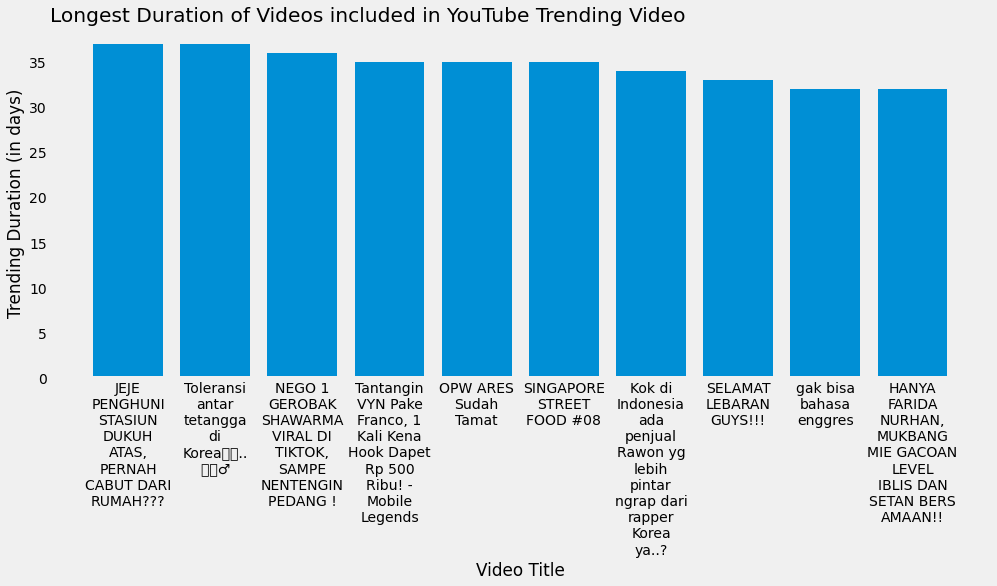

In [16]:
# Visualisasi data trending dengan chart bar
plt.figure(figsize=(15, 6))
plt.bar(
 trending_duration.title[:10].apply(lambda title: "\n".join(wrap(title, width=10))),
 trending_duration.trending_duration[:10]
)
plt.title("Longest Duration of Videos included in YouTube Trending Video", loc="left")
plt.xlabel("Video Title")
plt.ylabel("Trending Duration (in days)")
plt.grid(False)
plt.show()

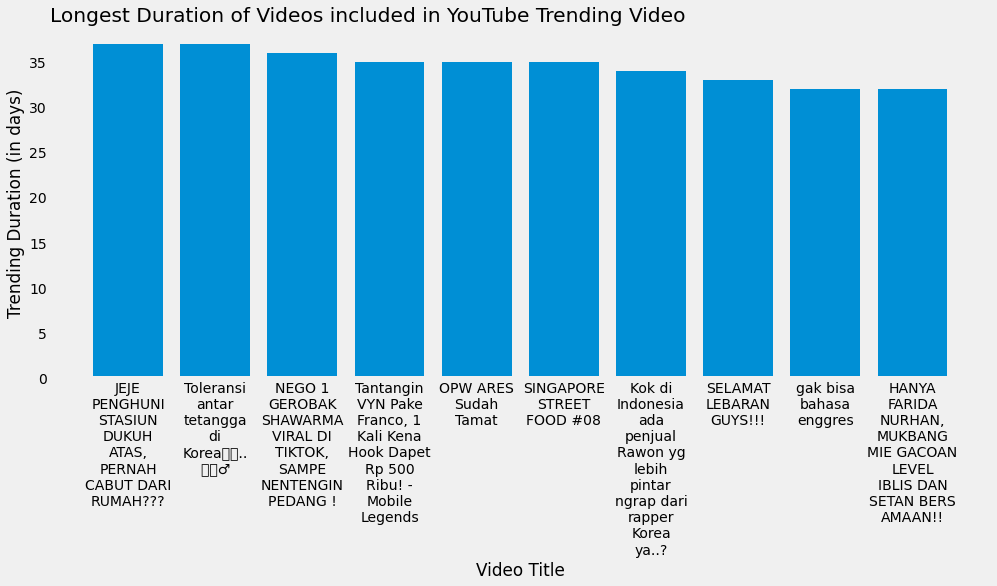

In [17]:
plt.figure(figsize=(15, 6))
plt.bar(
 trending_duration.title[:10].apply(lambda title: "\n".join(wrap(title, width=10))),
 trending_duration.trending_duration[:10]
)
plt.title("Longest Duration of Videos included in YouTube Trending Video", loc="left")
plt.xlabel("Video Title")
plt.ylabel("Trending Duration (in days)")
plt.grid(False)
plt.show()

In [18]:
trending_by_title = filtered_trending.groupby("title")
trending_rewind = trending_by_title[["view", "like", "dislike"]].agg(["min", "max", "mean", "sum"])
trending_rewind

view             \
                                                          min        max   
title                                                                      
"Awalnya Diserang Bertubi tubi" Lihatlah Bagaim...   101823.0   121044.0   
"BABY R" BIKIN GEMES !!! RAFATHAR CEMBURU, SEMU...  2280620.0  2637486.0   
"Emosi Rico Simanjutak" Saat Taisei Marukawa Be...    72434.0   116310.0   
"Grebek rumah harris vriza, dan percintaannya d...    68879.0   163773.0   
"Hellevator" Band Cover By Xdinary Heroes (원곡 :...   393043.0  1348612.0   
...                                                       ...        ...   
🥘Yuk! Kita coba in! Let’s eat | WayV’s ONE-DAY ...   148668.0   680210.0   
🥰 New Gadgets & Versatile Utensils For Home # 2...   330156.0  7334655.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...   278942.0  1212522.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...   320084.0  1097903.0   
🩸괴담회에 어서오세요🩸: 첫 번째 이야기 | WELCOME TO NCT’S HORRO...  1423178.0  2966798.0   

                                                                              \
                                                            mean         sum   
title                                                                          
"Awalnya Diserang Bertubi tubi" Lihatlah Bagaim...  1.114335e+05    222867.0   
"BABY R" BIKIN GEMES !!! RAFATHAR CEMBURU, SEMU...  2.459053e+06   4918106.0   
"Emosi Rico Simanjutak" Saat Taisei Marukawa Be...  9.390625e+04    375625.0   
"Grebek rumah harris vriza, dan percintaannya d...  1.267565e+05    760539.0   
"Hellevator" Band Cover By Xdinary Heroes (원곡 :...  1.126182e+06  14640369.0   
...                                                          ...         ...   
🥘Yuk! Kita coba in! Let’s eat | WayV’s ONE-DAY ...  5.519997e+05   8831995.0   
🥰 New Gadgets & Versatile Utensils For Home # 2...  3.414214e+06  34142143.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...  7.948737e+05   5564116.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...  7.562497e+05   4537498.0   
🩸괴담회에 어서오세요🩸: 첫 번째 이야기 | WELCOME TO NCT’S HORRO...  2.629831e+06  36817634.0   

                                                        like            \
                                                         min       max   
title                                                                    
"Awalnya Diserang Bertubi tubi" Lihatlah Bagaim...    1336.0    1456.0   
"BABY R" BIKIN GEMES !!! RAFATHAR CEMBURU, SEMU...   93348.0  101207.0   
"Emosi Rico Simanjutak" Saat Taisei Marukawa Be...     990.0    1432.0   
"Grebek rumah harris vriza, dan percintaannya d...    5529.0    8714.0   
"Hellevator" Band Cover By Xdinary Heroes (원곡 :...  127824.0  262846.0   
...                                                      ...       ...   
🥘Yuk! Kita coba in! Let’s eat | WayV’s ONE-DAY ...   39847.0  101922.0   
🥰 New Gadgets & Versatile Utensils For Home # 2...    2822.0   58066.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...    2790.0   10212.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...    3025.0    8759.0   
🩸괴담회에 어서오세요🩸: 첫 번째 이야기 | WELCOME TO NCT’S HORRO...  316849.0  457809.0   

                                                                              \
                                                             mean        sum   
title                                                                          
"Awalnya Diserang Bertubi tubi" Lihatlah Bagaim...    1396.000000     2792.0   
"BABY R" BIKIN GEMES !!! RAFATHAR CEMBURU, SEMU...   97277.500000   194555.0   
"Emosi Rico Simanjutak" Saat Taisei Marukawa Be...    1228.500000     4914.0   
"Grebek rumah harris vriza, dan percintaannya d...    7486.833333    44921.0   
"Hellevator" Band Cover By Xdinary Heroes (원곡 :...  237112.769231  3082466.0   
...                                                           ...        ...   
🥘Yuk! Kita coba in! Let’s eat | WayV’s ONE-DAY ...   87227.125000  1395634.0   
🥰 New Gadgets & Versatile Utensils

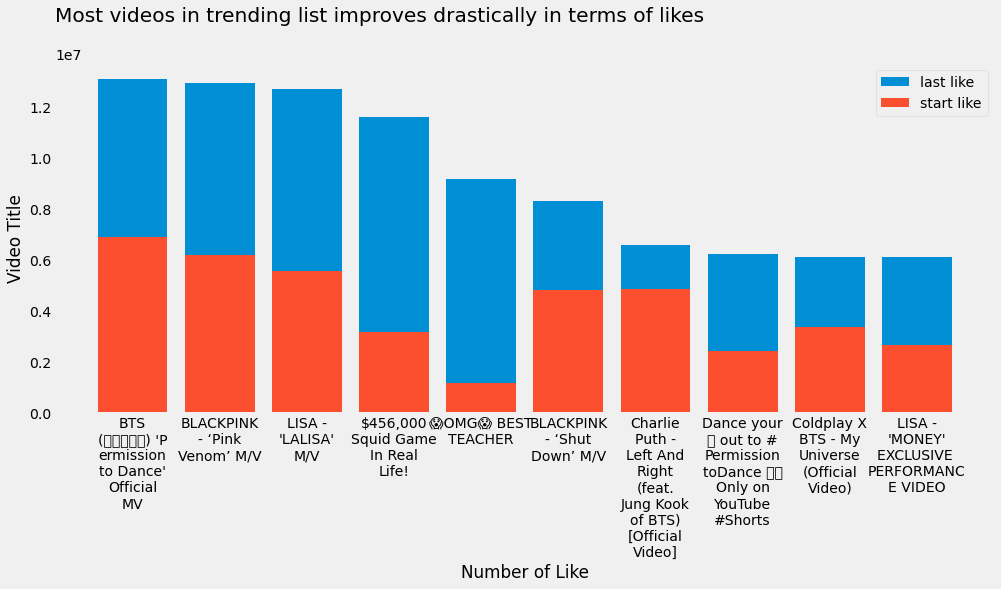

In [19]:
# Visualisasi Trending video teratas masing2
top_10_liked = trending_rewind["like"].sort_values("max", ascending=False).iloc[:10]
plt.figure(figsize=(15, 6))
plt.bar(
 top_10_liked.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
 top_10_liked["max"],
 label="last like"
)
plt.bar(
 top_10_liked.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
 top_10_liked["min"],
 label="start like"
)
plt.title("Most videos in trending list improves drastically in terms of likes", loc="left", y=1.1)
plt.xlabel("Number of Like")
plt.ylabel("Video Title")
plt.legend()
plt.grid(False)
plt.show()


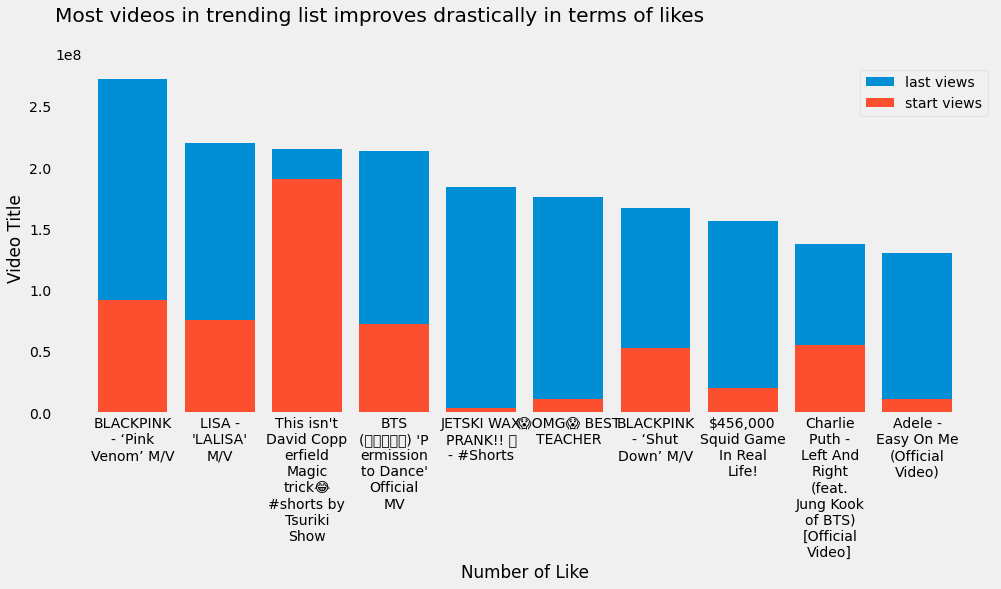

In [20]:
top_10_viewed = trending_rewind["view"].sort_values("max", ascending=False).iloc[:10]
plt.figure(figsize=(15, 6))
plt.bar(
 top_10_viewed.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
 top_10_viewed["max"],
 label="last views"
)
plt.bar(
 top_10_viewed.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
 top_10_viewed["min"],
 label="start views"
)
plt.title("Most videos in trending list improves drastically in terms of likes", loc="left", y=1.1)
plt.xlabel("Number of Like")
plt.ylabel("Video Title")
plt.legend()
plt.grid(False)
plt.show()

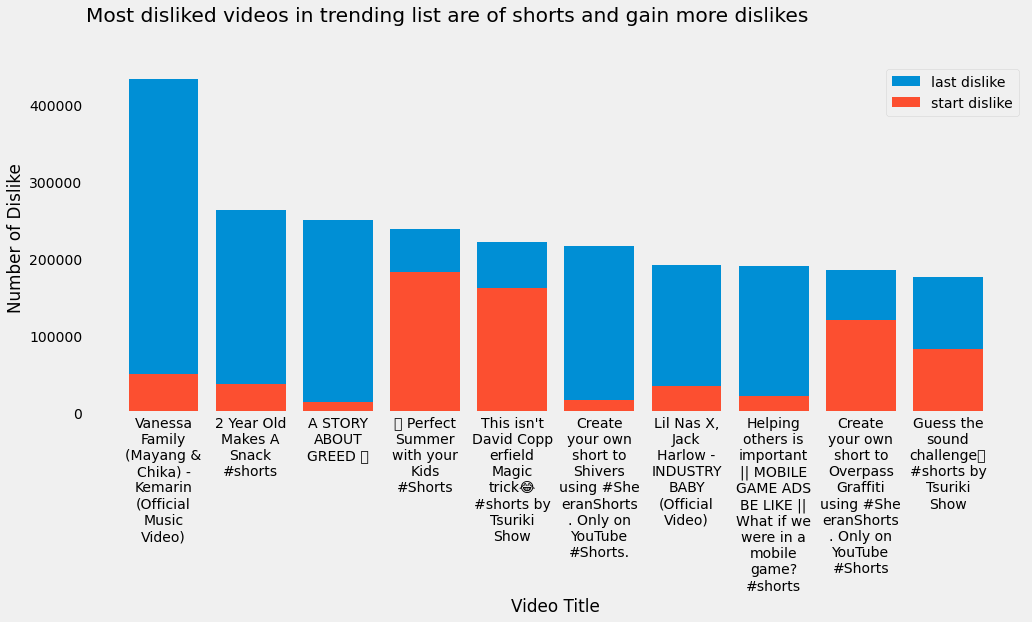

In [21]:
top_10_disliked = trending_rewind["dislike"].sort_values("max", ascending=False).iloc[:10]
plt.figure(figsize=(15, 6))
plt.bar(
 top_10_disliked.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
 top_10_disliked["max"],
 label="last dislike"
)
plt.bar(
 top_10_disliked.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
 top_10_disliked["min"],
 label="start dislike"
)
plt.title("Most disliked videos in trending list are of shorts and gain more dislikes", loc="left", y=1.1)
plt.ylabel("Number of Dislike")
plt.xlabel("Video Title")
plt.legend()
plt.grid(False)
plt.show()

In [22]:
# Sebagai contoh, perhatikan sampel judul dan deskripsi video berikut.
sample = filtered_trending.sample(10, random_state=11)
sample[["title", "description"]]

,title,description
50234,MAN CITY 3-0 EVERTON | PREMIER LEAGUE HIGHLIGHTS,Everton fell to defeat at Manchester City in a...
22694,Idgitaf - Berlagak Bahagia (Official Lyric Video),Berlagak Bahagia (Official Lyric Video)\nStrea...
93064,Seharian ngerasain kerjaan jadi SALES HP!,Boleh hape murah kaka...\n\nBarang bekas revie...
47387,UPDATE TERBARU VERSI 1.038.85!! MOTOR BARU LAN...,Hello guys..kita lanjut lagi main Sakura Schoo...
37865,Persaingan Pedagang Bakso – tebar tanah kubura...,Join this channel to get access to perks:\nhtt...
103946,"Melly Goeslaw, Lesti, Nagita Slavina, Celine E...","RUMAH KITA - MELLY GOESLAW, NAGITA SLAVINA, LE..."
53471,"KISAH HARU RUMINI, Meninggal Berpelukan Bersam...","SURYA.co.id, LUMAJANG - Korban meninggal letus..."
103941,EPIC Leon Edwards' coaches inspire him to incr...,Leon Edwards did the unthinkable by defeating ...
42589,TANTANGAN MENGHIAS KEIK || Putar Roda Misterin...,"Kalau kita membayangkan keik, kita pasti ngeba..."
107739,Teaser | Percy Jackson and the Olympians | Dis...,"For more updates, subscribe to Disney, Pixar, ..."


In [23]:
# Merubah title dan descripsi video menjadi lowercase
sample["title_lang"] = sample.title.apply(lambda title: langdetect.detect(title.lower()))
sample["desc_lang"] = sample.description.apply(lambda desc: langdetect.detect(desc.lower()))

In [24]:
with pd.option_context("display.max_colwidth", 100):
 display(sample[["title", "title_lang", "description", "desc_lang"]])

,title,title_lang,description,desc_lang
50234,MAN CITY 3-0 EVERTON | PREMIER LEAGUE HIGHLIGHTS,en,Everton fell to defeat at Manchester City in a difficult afternoon at Etihad Stadium. Raheem Ste...,en
22694,Idgitaf - Berlagak Bahagia (Official Lyric Video),en,"Berlagak Bahagia (Official Lyric Video)\nStream ""Berlagak Bahagia"" in your favorite platform: ht...",en
93064,Seharian ngerasain kerjaan jadi SALES HP!,id,Boleh hape murah kaka...\n\nBarang bekas review biasanya saya jual disini: https://invol.co/cl75...,id
47387,UPDATE TERBARU VERSI 1.038.85!! MOTOR BARU LANGSUNG BUAT BALAPAN!! SAKURA SCHOOL SIMULATOR-PART 494,id,Hello guys..kita lanjut lagi main Sakura School Part 494 yaa. Kali ini Sakurani Review UPDATE T...,id
37865,Persaingan Pedagang Bakso – tebar tanah kuburan agar bangkrut #HORORMISTERI | Kartun hantu pocong,id,Join this channel to get access to perks:\nhttps://www.youtube.com/channel/UC7GWXKxiy9_AU9TytEh0...,id
103946,"Melly Goeslaw, Lesti, Nagita Slavina, Celine Evangelista - Rumah Kita | Official Music Video",it,"RUMAH KITA - MELLY GOESLAW, NAGITA SLAVINA, LESTI, CELINE EVANGELISTA\n#RumahKita #PulihLebihCep...",id
53471,"KISAH HARU RUMINI, Meninggal Berpelukan Bersama Ibunya Digulung Wedhus Gembel Semeru",id,"SURYA.co.id, LUMAJANG - Korban meninggal letusan Semeru mulai ditemukan. Dua di antaranya adalah...",id
103941,EPIC Leon Edwards' coaches inspire him to incredible comeback win! | Usman v Edwards 2 | UFC 278,en,Leon Edwards did the unthinkable by defeating Kamaru Usman and becoming the UFC welterweight Cha...,en
42589,TANTANGAN MENGHIAS KEIK || Putar Roda Misterinya! 100 Lapis MAKANAN oleh 123 GO! CHALLENGE,id,"Kalau kita membayangkan keik, kita pasti ngebayangin berlapis-lapis dengan cokelat manis, tabura...",id
107739,Teaser | Percy Jackson and the Olympians | Disney+,en,"For more updates, subscribe to Disney, Pixar, Marvel, Star Wars, and National Geographic.\n \nDi...",en


In [25]:
# Pertama, kita akan buat fungsi yang akan mendeteksi bahasa dari sebuah teks sebagai berikut.
def detect_language(text):
 """Detect language of the 'text'."""
 try:
    lang = langdetect.detect(text)
    return lang
 except:
      return

In [26]:
def detect_language(text):
 """Detect language of the 'text'."""
 try:
      lang = langdetect.detect(text)
      return lang
 except:
      return

In [29]:
filtered_trending["title_lang"] = filtered_trending["title"].apply(detect_language)
filtered_trending["desc_lang"] = filtered_trending["description"].apply(detect_language)

In [28]:
filtered_trending[["title", "title_lang", "description", "desc_lang"]]

,title,title_lang,description,desc_lang
21322,NCT DREAM 엔시티 드림 'Hello Future' MV,it,"NCT DREAM's 1st Album Repackage ""Hello Future""...",en
21323,PART 3 // SUTRISNO DAN ENDANG BAHAGIA,de,Find me on sosial media :\n\nInstagram : https...,en
21324,This isn't David Copperfield Magic trick😂 #sho...,en,Thank you for watching.\nSubscribe to Tsuriki ...,en
21325,Rizky Billar - Pemimpinmu | Official Music Video,en,Rizky Billar - Pemimpinmu | Official Music Vid...,id
21326,Ini Pengakuan Pengemudi Pajero usai Rusak dan ...,id,Polisi menangkap pengemudi SUV yang merusak da...,id
...,...,...,...,...
118746,NASI GORENG BAKAR INI PINDAH SAMPAI 13 KALI KA...,de,HAHHH JUALAN NASI GORENG INI UDAH 13 KALI PIND...,id
118747,"KENAL DEKAT DENGAN KELUARGA NATHALIE, PAPA SAY...",de,"Hi, welcome to Nathalie Holscher Channel!\n\nF...",id
118748,YOUNITE 'Bad Cupid' M/V,en,YOUNITE 'Bad Cupid' M/V\n\n'YOUNI-ON' Availabl...,en
118749,Cover | JAEHYUN - Can't Take My Eyes Off You (...,en,#Cover #JAEHYUN\n#CantTakeMyEyesOffYou #Franki...,en


In [30]:
indo_trending = filtered_trending.loc[
 (filtered_trending.title_lang == "id") | (filtered_trending.desc_lang == "id")
]
with pd.option_context("display.max_columns", None):
 display(indo_trending.sample(10))

,video_id,publish_time,channel_id,title,description,thumbnail_url,thumbnail_width,thumbnail_height,channel_name,tags,category_id,live_status,local_title,local_description,duration,dimension,definition,caption,license_status,allowed_region,blocked_region,view,like,dislike,favorite,comment,trending_time,title_lang,desc_lang
100776,waawDg_VbOI,2022-08-17 06:34:00+00:00,UC5BMIWZe9isJXLZZWPWvBlg,"Nyanyi ""Ojo Dibandingke"", Farel Bikin Presiden...",#jokowi #farel #ojodibandingke \n\nJangan lewa...,https://i.ytimg.com/vi/waawDg_VbOI/hqdefault.jpg,480.0,360.0,KOMPASTV,"['berita kompas', 'berita kompastv', 'kompasne...",25,none,"Nyanyi ""Ojo Dibandingke"", Farel Bikin Presiden...",#jokowi #farel #ojodibandingke \n\nJangan lewa...,PT14M25S,2d,hd,False,True,NaN,NaN,8729525.0,185825.0,NaN,0,19973.0,2022-08-22 06:01:47.571024+00:00,id,id
55459,MuE_5K8br9c,2021-12-16 08:11:06+00:00,UCvA9_f5Lwk-poMynabtrZPg,KENANGAN TERAKHIR BARENG LAURA! KAMU KUAT KAMU...,Subscribe:\nRans Animation Studio: https://www...,https://i.ytimg.com/vi/MuE_5K8br9c/hqdefault.jpg,480.0,360.0,Rans Entertainment,"['rans', 'raffi ahmad', 'nagita', 'nagita slav...",24,none,KENANGAN TERAKHIR BARENG LAURA! KAMU KUAT KAMU...,Subscribe:\nRans Animation Studio: https://www...,PT40M51S,2d,hd,False,True,NaN,NaN,9269084.0,490618.0,NaN,0,11037.0,2021-12-20 06:01:35.470542+00:00,id,en
100867,tFbnJ70sbJY,2022-08-13 06:00:10+00:00,UCI2eaAffV9HFhYpNX1PiCEg,"KUMAL #1 Main kuis, rizky nazar malah kecepl...",Hai guys! I hope you enjoy this video~\n\n\n\n...,https://i.ytimg.com/vi/tFbnJ70sbJY/hqdefault.jpg,480.0,360.0,Rizkina Nazar,"['Rizkina nazar', 'Rizkina vlog', 'Rizky nazar...",22,none,"KUMAL #1 Main kuis, rizky nazar malah kecepl...",Hai guys! I hope you enjoy this video~\n\n\n\n...,PT10M32S,2d,hd,False,True,NaN,NaN,242989.0,14483.0,NaN,0,232.0,2022-08-22 06:01:47.572464+00:00,id,en
21422,NaN,2021-06-21 10:46:58+00:00,UCJpdpj9hNhaYBRGusGv7CjQ,Viral Pelanggar Lalu Lintas Ditegur di Traffic...,Dinas Perhubungan (Dishub) Gianyar memasang pe...,NaN,NaN,NaN,Tribun Jateng,"['gianyar', 'bali', 'gianyar bali', 'cctv lalu...",25,none,Viral Pelanggar Lalu Lintas Ditegur di Traffic...,Dinas Perhubungan (Dishub) Gianyar memasang pe...,PT5M16S,2d,hd,False,True,NaN,NaN,897052.0,9594.0,426.0,0,2698.0,2021-07-01 06:01:25.525582+00:00,id,id
103146,heCVaT72QJ8,2022-08-17 04:00:30+00:00,UCHb7bDmZ5AQJFQrGPntk3fg,Minecraft One Block Tapi Sangat Terlalu Keciii...,- Subcribe Gratis : https://goo.gl/9DnNkc\n- J...,https://i.ytimg.com/vi/heCVaT72QJ8/hqdefault.jpg,480.0,360.0,Teguh Sugianto,"['Teguh Sugianto', 'Teguh Sugianto Minecraft',...",20,none,Minecraft One Block Tapi Sangat Terlalu Keciii...,- Subcribe Gratis : https://goo.gl/9DnNkc\n- J...,PT18M43S,2d,hd,False,True,NaN,NaN,560402.0,19487.0,NaN,0,817.0,2022-09-02 06:01:33.780340+00:00,ro,id
109533,WrO_hmYr-yw,2022-09-18 09:00:12+00:00,UCp7JIVbYW5cq86ifi68yDmQ,ERROR.. MAKAN BAKSO KETUMPAHAN CABE!!! RASANYA...,Bakso Benny Kemayoran\nAlamat: Jl. Kali Baru T...,https://i.ytimg.com/vi/WrO_hmYr-yw/hqdefault.jpg,480.0,360.0,Anak Kuliner,"['makan', 'makanan', 'kuliner', 'nusantara', '...",22,none,ERROR.. MAKAN BAKSO KETUMPAHAN CABE!!! RASANYA...,Bakso Benny Kemayoran\nAlamat: Jl. Kali Baru T...,PT11M18S,2d,hd,False,True,NaN,NaN,324069.0,7072.0,NaN,0,278.0,2022-10-04 06:01:43.740676+00:00,so,id
24557,NaN,2021-07-10 11:00:14+00:00,UCLiy-C7YdWBxg8D9XWxWq1w,"DIKASIH KEJUTAN ULTAH, AYU TING TING MINTA DIN...","Hari ini Ditanya Robby, disini kita akan buka ...",NaN,NaN,NaN,Robby Purba,"['Robby Purba', 'bada maghrib', ""ba'da maghrib...",24,none,"DIKASIH KEJUTAN ULTAH, AYU TING TING MINTA DIN...","Hari ini Ditanya Robby, disini kita akan buka ...",PT24M30S,2d,hd,False,True,NaN,NaN,1163159.0,37997.0,1138.0,0,3780.0,2021-07-17 06:02:51.152250+00:00,de,id
51060,NaN,2021-11-17 02:00:14+00:00,UChFv0WPR47xMAPpCJWUgk1Q,Esa Risty - Hendaklah Cari Pengganti - ER Musi...,Official Music Video from Esa Risty - Hendakla...,NaN,NaN,NaN,Esa Risty Official,"['Hendaklah cari pengga

In [31]:
data = indo_trending[["title", "description", "category_id"]].reset_index(drop=True)
data

,title,description,category_id
0,Rizky Billar - Pemimpinmu | Official Music Video,Rizky Billar - Pemimpinmu | Official Music Vid...,10
1,Ini Pengakuan Pengemudi Pajero usai Rusak dan ...,Polisi menangkap pengemudi SUV yang merusak da...,25
2,Aksi Demo Tolak Kedatangan Jokowi di Kendari B...,Tanggal Tayang: 30/06/2021\n\nProgram berita h...,25
3,"PERTAMA KALI LIAT SAPI SEGEDE GINI, DINAIKIN D...",Assalamualaikum gaeess..! sudah nonton video s...,15
4,PODKESMAS SAMPAI GA NYAMAN DIBAHAS DISINI - To...,Talk show malam yang akan memberikan informasi...,24
...,...,...,...
38000,Ariel NOAH x Enda Ungu - Yang Terdalam (Live a...,Ariel NOAH x Enda Ungu - Yang Terdalam\n\nOrig...,10
38001,Farel Prayoga Feat Dini Kurnia _CINTA TAK TERP...,Farel Prayoga Feat Dini Kurnia _CINTA TAK TERP...,10
38002,NASI GORENG BAKAR INI PINDAH SAMPAI 13 KALI KA...,HAHHH JUALAN NASI GORENG INI UDAH 13 KALI PIND...,22
38003,"KENAL DEKAT DENGAN KELUARGA NATHALIE, PAPA SAY...","Hi, welcome to Nathalie Holscher Channel!\n\nF...",24


In [32]:
data.drop_duplicates(subset="title", inplace=True)

In [33]:
data.reset_index(drop=True, inplace=True)
data.shape

(6158, 3)

In [37]:
list_emoji = [e for e in emoji.UNICODE_EMOJI.get("en")]

count = 0
for em in list_emoji:
    for title in data.title:
        if em in title:
            count += 1
print("How many titles use emoji?", count)

AttributeError: module 'emoji' has no attribute 'UNICODE_EMOJI'

In [38]:
def demojize(text):
for em in list_emoji:
if em in text:
em_text = emoji.demojize(em)
text = text.replace(em, " " + em_text + " ")
return text

IndentationError: expected an indented block (<ipython-input-38-dce411e8c4ca>, line 2)

In [39]:
def demojize(text):
for em in list_emoji:
if em in text:
em_text = emoji.demojize(em)
text = text.replace(em, " " + em_text + " ")
return text

IndentationError: expected an indented block (<ipython-input-39-dce411e8c4ca>, line 2)

In [40]:
title_with_emoji_idx = [
idx for idx in range(len(data.title))
for em in list_emoji
if em in data.loc[idx, "title"]
]

NameError: name 'list_emoji' is not defined

In [41]:
with pd.option_context("display.max_colwidth", 100):
display(data.loc[title_with_emoji_idx])

IndentationError: expected an indented block (<ipython-input-41-21ad26ebe5a2>, line 2)

In [42]:
data.drop(columns="title", inplace=True)

In [43]:
desc_with_emoji_idx = [
idx for idx in range(len(data.description))
for em in list_emoji
if em in data.loc[idx, "description"]
]
data["desc_emoji"] = data.description.apply(demojize)
with pd.option_context("display.max_colwidth", 100):
display(data.loc[desc_with_emoji_idx])

IndentationError: expected an indented block (<ipython-input-43-ca0d49ba4242>, line 8)

In [44]:
data.drop(columns="description", inplace=True)

In [45]:
data["all_text"] = data["title_emoji"] + " " + data["desc_emoji"]

KeyError: 'title_emoji'

In [46]:
# data split
X_train, X_dev, y_train, y_dev = train_test_split(
data["all_text"], data["category_id"],
test_size=.2,
stratify=data["category_id"],
random_state=11
)
training_size = X_train.shape[0]
dev_size = X_dev.shape[0]
print(f"{training_size = }.. {dev_size = }")
# define vectorizer
vectorizer = TfidfVectorizer(
min_df=.015,
max_df=.7,
ngram_range=(1, 1),
)
# generate tf-idf matrix
train_tfidf = vectorizer.fit_transform(X_train)
dev_tfidf = vectorizer.transform(X_dev)
print("Got train tf-idf with shape:", train_tfidf.shape)
print("Got dev tf-idf with shape:", dev_tfidf.shape)
# convert to dataframe
train_tfidf = pd.DataFrame(train_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
dev_tfidf = pd.DataFrame(dev_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

KeyError: 'all_text'

In [47]:
with pd.option_context("display.max_columns", 100):
display(train_tfidf.sample(5))

IndentationError: expected an indented block (<ipython-input-47-14ef32862dcf>, line 2)

In [48]:
data.drop(columns="title", inplace=True)

KeyError: "['title'] not found in axis"

In [49]:
desc_with_emoji_idx = [
idx for idx in range(len(data.description))
for em in list_emoji
if em in data.loc[idx, "description"]
]
data["desc_emoji"] = data.description.apply(demojize)
with pd.option_context("display.max_colwidth", 100):
display(data.loc[desc_with_emoji_idx])

IndentationError: expected an indented block (<ipython-input-49-ca0d49ba4242>, line 8)

In [50]:
data.drop(columns="description", inplace=True)

KeyError: "['description'] not found in axis"

In [51]:
data["all_text"] = data["title_emoji"] + " " + data["desc_emoji"]

KeyError: 'title_emoji'

In [52]:
# data split
X_train, X_dev, y_train, y_dev = train_test_split(
data["all_text"], data["category_id"],
test_size=.2,
stratify=data["category_id"],
random_state=11
)
training_size = X_train.shape[0]
dev_size = X_dev.shape[0]
print(f"{training_size = }.. {dev_size = }")
# define vectorizer
vectorizer = TfidfVectorizer(
min_df=.015,
max_df=.7,
ngram_range=(1, 1),
)
# generate tf-idf matrix
train_tfidf = vectorizer.fit_transform(X_train)
dev_tfidf = vectorizer.transform(X_dev)
print("Got train tf-idf with shape:", train_tfidf.shape)
print("Got dev tf-idf with shape:", dev_tfidf.shape)
# convert to dataframe
train_tfidf = pd.DataFrame(train_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
dev_tfidf = pd.DataFrame(dev_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

KeyError: 'all_text'

In [53]:
with pd.option_context("display.max_columns", 100):
display(train_tfidf.sample(5))

IndentationError: expected an indented block (<ipython-input-53-14ef32862dcf>, line 2)

In [54]:
dict_models = {
"logistic_regression": LogisticRegression(),
"naive_bayes": MultinomialNB(),
"svm": LinearSVC(random_state=11),
"decision_tree": DecisionTreeClassifier(random_state=11),
"random_forest": RandomForestClassifier(random_state=11)
}

In [55]:
for model in dict_models.values():
print(f"-- {model.__class__.__name__} --")
model.fit(train_tfidf, y_train)
y_pred = model.predict(dev_tfidf)
print("Reports on dev set:", classification_report(y_dev, y_pred), sep="\n")

IndentationError: expected an indented block (<ipython-input-55-7e7bf51302a2>, line 2)

In [56]:
svm_grid_search = GridSearchCV(
dict_models["svm"],
{"C": (10, 1, .1, .05, .01)},
)
svm_grid_search.fit(train_tfidf, y_train)
svm_pred_dev = svm_grid_search.predict(dev_tfidf)
print("Reports on train set:",
classification_report(
y_train,
svm_grid_search.predict(train_tfidf)
), sep="\n")
print("Reports on dev set:", classification_report(y_dev, svm_pred_dev), sep="\n")

NameError: name 'train_tfidf' is not defined

In [57]:
svm_grid_search.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [58]:
random_forest_grid_search = GridSearchCV(
dict_models["random_forest"],
{
"n_estimators": (10, 20, 25, 50, 75, 100, 125),
"max_depth": (5, 10, 25, 50),
}
)
random_forest_grid_search.fit(train_tfidf, y_train)
random_forest_pred = random_forest_grid_search.predict(dev_tfidf)
print("Reports on train set:",
classification_report(
y_train,
random_forest_grid_search.predict(train_tfidf)
),
sep="\n"
)
print("Reports on dev set:", classification_report(y_dev, random_forest_pred), sep="\n")

NameError: name 'train_tfidf' is not defined

In [59]:
model = Pipeline([
("vectorizer", TfidfVectorizer(
min_df=.015,
max_df=.7,
ngram_range=(1, 1),
)),
("model", RandomForestClassifier(
max_depth=50,
n_estimators=75,
random_state=11
))
])
# training
model.fit(X_train, y_train)
pred = model.predict(X_dev)
print("Reports on train set:",
classification_report(
y_train,
model.predict(X_train)
),
sep="\n"
)
print("Reports on dev set:", classification_report(y_dev, pred), sep="\n")

NameError: name 'X_train' is not defined

In [60]:
joblib.dump(model, "D:/archive")

PermissionError: [Errno 13] Permission denied: 'D:/archive'

In [61]:
preds = model.predict(X_dev)
print(classification_report(y_dev, preds))

NameError: name 'X_dev' is not defined